# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

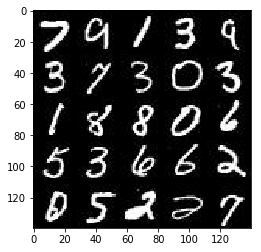

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

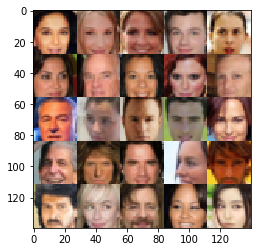

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="SAME")
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding="SAME")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="SAME")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7 x 7 x 256
        # Flatten it
        flat = tf.reshape(relu3, [-1, 7*7*256])
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7 * 7 * 256)

        # 7x7x256 > 14x14x128 > 14x14x64 > 28x28x1/3
        # reshape it to start the convolution stack
        x1 = tf.reshape(x1, [-1, 7, 7, 256])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha , x1)
        # 7x7x256

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14 * 14 * 128

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14 * 14 * 64

        # output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    # fake是根据input_z生成的模型
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # 真实图片都是1 生成图片都是0
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    # 要让生成的图片尽量真实
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    steps = 0
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, 1 if data_image_mode=='L' else 3)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images,input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z})
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z:batch_z, input_real:batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
#                     losses.append((train_loss_d, train_loss_g))
#                     show_generator_output(sess, 5, input_z, 1 if data_image_mode=='L' else 3, data_image_mode)
                    
                if steps % 50 == 0:
                    show_generator_output(sess, 5, input_z, 1 if data_image_mode=='L' else 3, data_image_mode)
                    gen_samples = sess.run(
                                   generator(input_z, 1 if data_image_mode=='L' else 3, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 5, input_z, 1 if data_image_mode=='L' else 3, data_image_mode)
#                     _ = view_samples(-1, samples, 5, 10, figsize=figsize)
#                     plt.show()

        saver.save(sess, './generator.ckpt')

        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    print("Training done!")
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0730... Generator Loss: 3.0271
Epoch 1/2... Discriminator Loss: 0.1453... Generator Loss: 2.5053


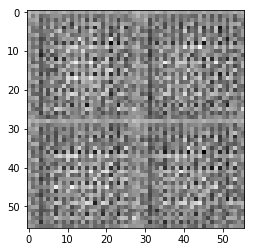

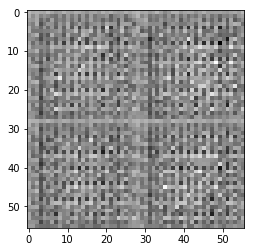

Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 1.5518


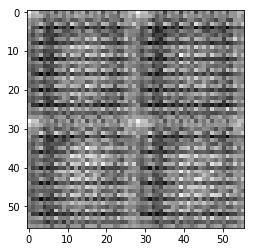

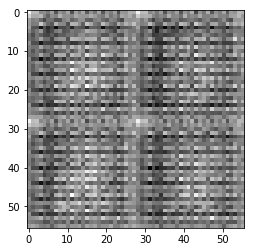

Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 0.3268... Generator Loss: 2.2950


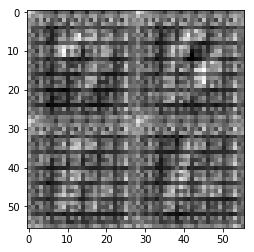

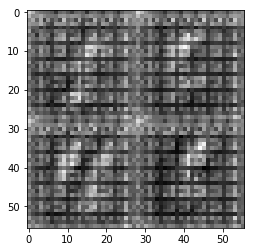

Epoch 1/2... Discriminator Loss: 0.3245... Generator Loss: 2.1785
Epoch 1/2... Discriminator Loss: 0.5656... Generator Loss: 1.2185
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 1.4729


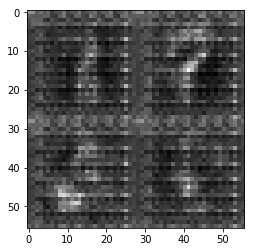

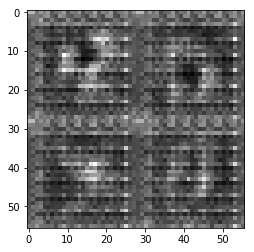

Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 0.5170... Generator Loss: 2.1775


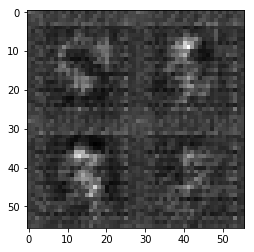

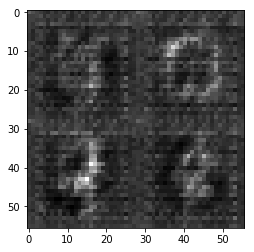

Epoch 1/2... Discriminator Loss: 0.9157... Generator Loss: 3.8651
Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 3.8661
Epoch 1/2... Discriminator Loss: 0.5393... Generator Loss: 1.0582


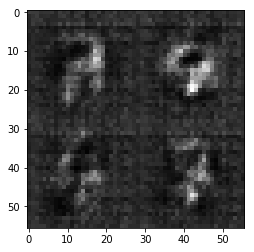

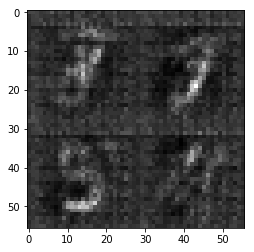

Epoch 1/2... Discriminator Loss: 0.3101... Generator Loss: 1.9573
Epoch 1/2... Discriminator Loss: 0.2182... Generator Loss: 2.0397


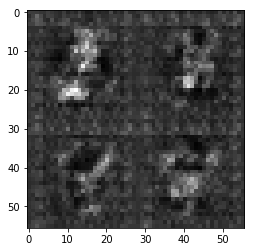

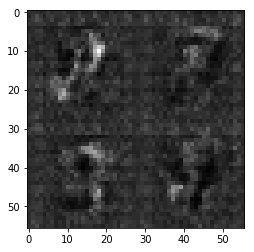

Epoch 1/2... Discriminator Loss: 0.2832... Generator Loss: 1.8500
Epoch 1/2... Discriminator Loss: 0.3158... Generator Loss: 2.0148
Epoch 1/2... Discriminator Loss: 0.5664... Generator Loss: 1.1078


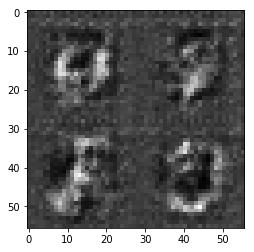

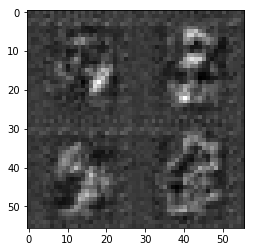

Epoch 1/2... Discriminator Loss: 0.3818... Generator Loss: 3.1026
Epoch 1/2... Discriminator Loss: 0.3673... Generator Loss: 1.8251


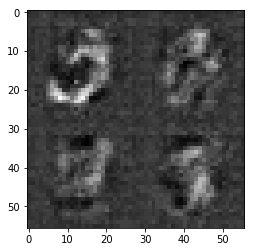

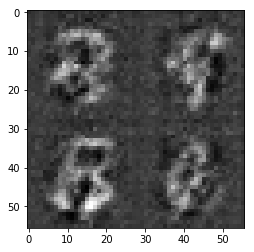

Epoch 1/2... Discriminator Loss: 0.2452... Generator Loss: 3.7150
Epoch 1/2... Discriminator Loss: 0.2542... Generator Loss: 2.0194
Epoch 1/2... Discriminator Loss: 0.2328... Generator Loss: 2.6208


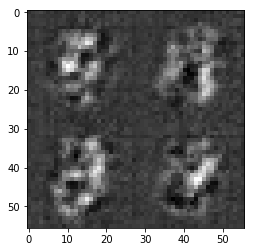

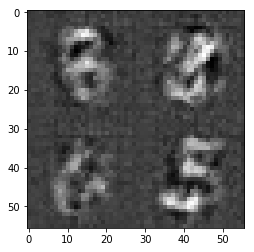

Epoch 1/2... Discriminator Loss: 0.2089... Generator Loss: 2.5717
Epoch 1/2... Discriminator Loss: 0.2024... Generator Loss: 2.8344


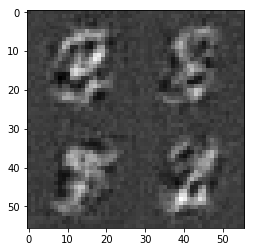

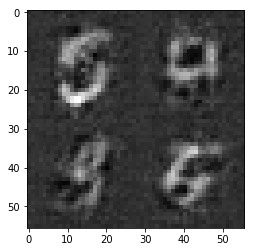

Epoch 1/2... Discriminator Loss: 0.2883... Generator Loss: 2.3116
Epoch 1/2... Discriminator Loss: 0.2398... Generator Loss: 2.1523
Epoch 1/2... Discriminator Loss: 0.2017... Generator Loss: 2.4515


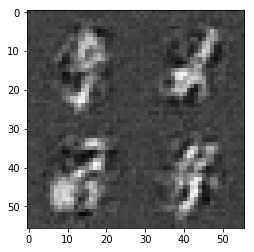

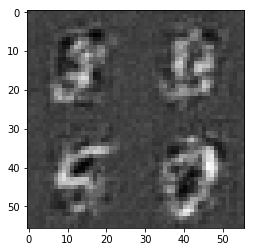

Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 2.5957
Epoch 1/2... Discriminator Loss: 0.1994... Generator Loss: 2.1554


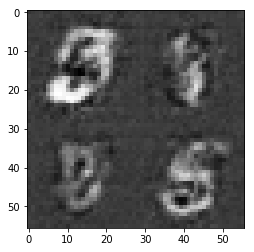

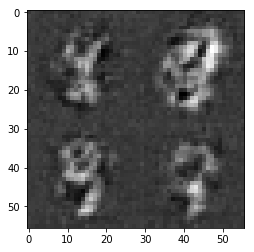

Epoch 1/2... Discriminator Loss: 0.1617... Generator Loss: 2.5779
Epoch 1/2... Discriminator Loss: 0.1590... Generator Loss: 2.7781
Epoch 1/2... Discriminator Loss: 0.1853... Generator Loss: 2.3645


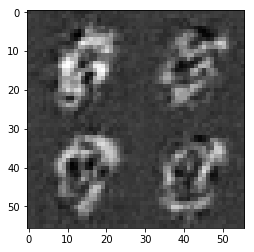

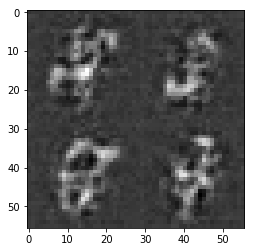

Epoch 1/2... Discriminator Loss: 0.1448... Generator Loss: 3.0207
Epoch 1/2... Discriminator Loss: 0.1407... Generator Loss: 2.5699


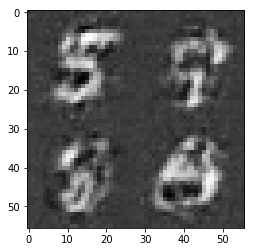

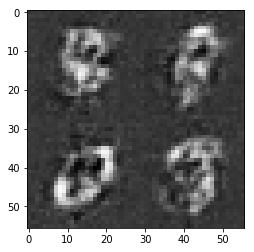

Epoch 1/2... Discriminator Loss: 0.1219... Generator Loss: 3.1771
Epoch 1/2... Discriminator Loss: 0.1165... Generator Loss: 3.1146
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 5.0883


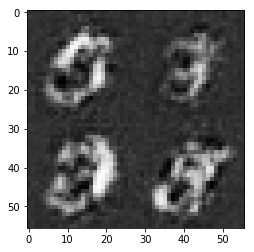

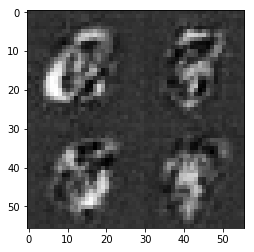

Epoch 1/2... Discriminator Loss: 0.1439... Generator Loss: 2.7537
Epoch 1/2... Discriminator Loss: 0.1212... Generator Loss: 2.9299


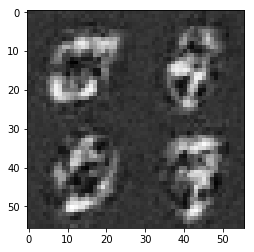

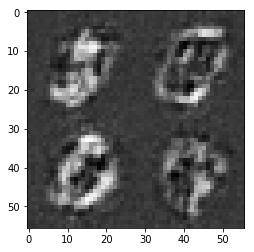

Epoch 1/2... Discriminator Loss: 0.1333... Generator Loss: 2.9288
Epoch 1/2... Discriminator Loss: 0.1033... Generator Loss: 2.9110
Epoch 1/2... Discriminator Loss: 0.1368... Generator Loss: 2.6693


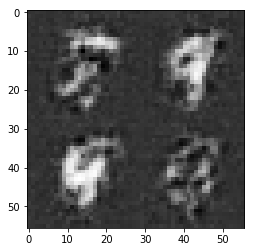

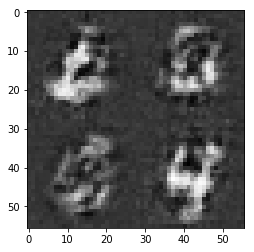

Epoch 1/2... Discriminator Loss: 0.0981... Generator Loss: 2.9118
Epoch 2/2... Discriminator Loss: 0.1128... Generator Loss: 2.9632


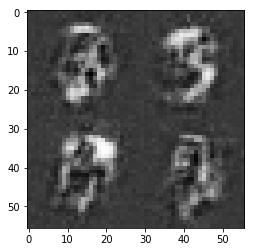

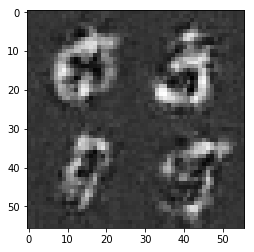

Epoch 2/2... Discriminator Loss: 0.1315... Generator Loss: 2.6268
Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 3.4083
Epoch 2/2... Discriminator Loss: 0.1016... Generator Loss: 3.0169


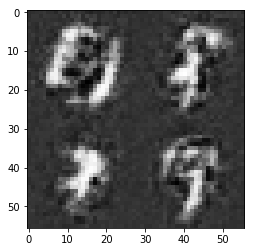

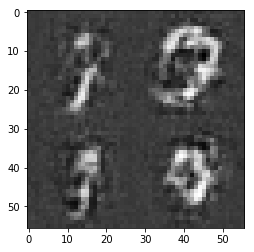

Epoch 2/2... Discriminator Loss: 0.0974... Generator Loss: 3.1293
Epoch 2/2... Discriminator Loss: 0.0936... Generator Loss: 2.9051


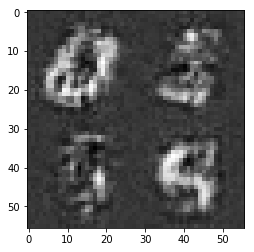

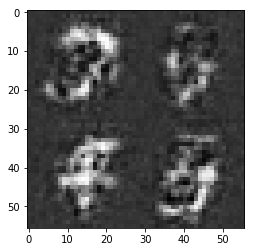

Epoch 2/2... Discriminator Loss: 0.0925... Generator Loss: 3.0448
Epoch 2/2... Discriminator Loss: 0.0935... Generator Loss: 2.8678
Epoch 2/2... Discriminator Loss: 0.0726... Generator Loss: 3.2939


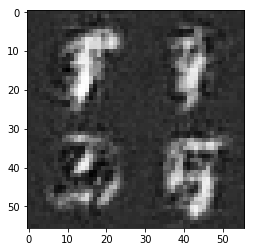

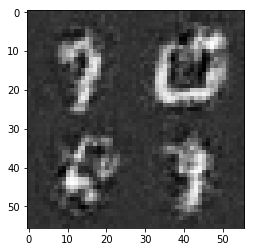

Epoch 2/2... Discriminator Loss: 0.0558... Generator Loss: 3.5451
Epoch 2/2... Discriminator Loss: 0.0657... Generator Loss: 3.4108


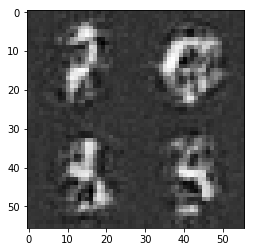

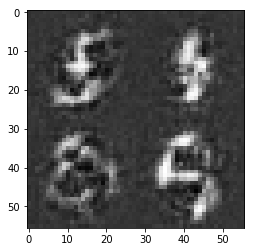

Epoch 2/2... Discriminator Loss: 0.0657... Generator Loss: 3.3364
Epoch 2/2... Discriminator Loss: 0.0825... Generator Loss: 3.0948
Epoch 2/2... Discriminator Loss: 0.0751... Generator Loss: 3.2202


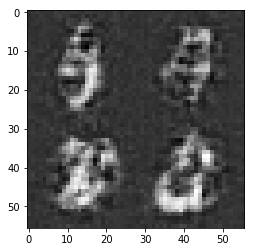

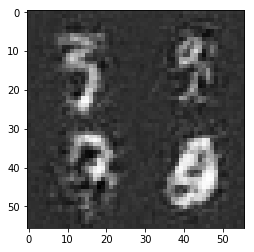

Epoch 2/2... Discriminator Loss: 0.0919... Generator Loss: 2.8136
Epoch 2/2... Discriminator Loss: 0.0726... Generator Loss: 3.1854


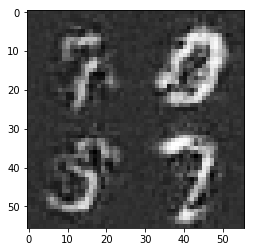

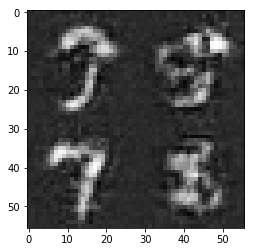

Epoch 2/2... Discriminator Loss: 0.0447... Generator Loss: 3.8392
Epoch 2/2... Discriminator Loss: 0.0642... Generator Loss: 3.4169
Epoch 2/2... Discriminator Loss: 0.0655... Generator Loss: 3.2759


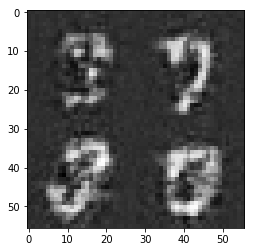

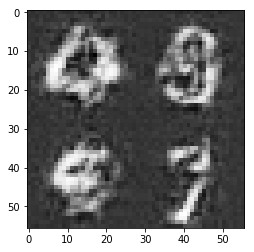

Epoch 2/2... Discriminator Loss: 0.0450... Generator Loss: 3.8842
Epoch 2/2... Discriminator Loss: 0.0465... Generator Loss: 3.7708


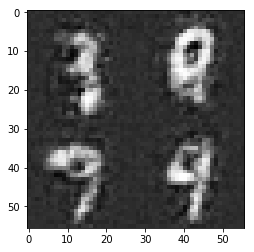

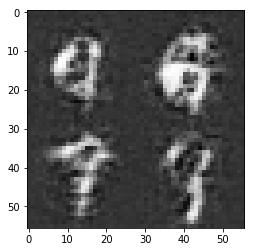

Epoch 2/2... Discriminator Loss: 0.0411... Generator Loss: 4.1788
Epoch 2/2... Discriminator Loss: 0.0638... Generator Loss: 3.4885
Epoch 2/2... Discriminator Loss: 0.0602... Generator Loss: 3.4801


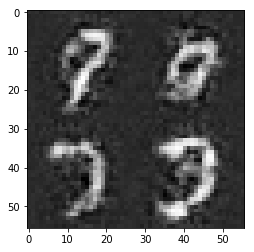

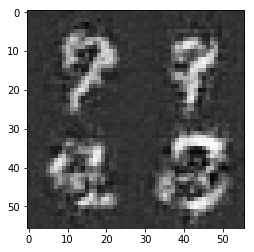

Epoch 2/2... Discriminator Loss: 0.0409... Generator Loss: 4.1475
Epoch 2/2... Discriminator Loss: 0.0477... Generator Loss: 3.5337


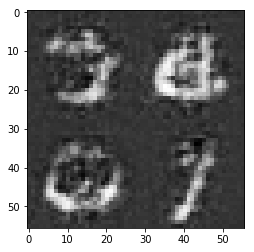

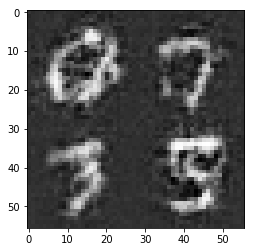

Epoch 2/2... Discriminator Loss: 0.0594... Generator Loss: 3.4814
Epoch 2/2... Discriminator Loss: 0.0656... Generator Loss: 3.3256
Epoch 2/2... Discriminator Loss: 0.0599... Generator Loss: 3.3141


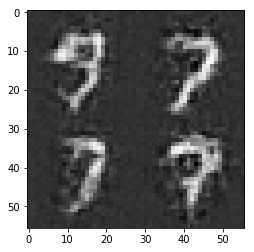

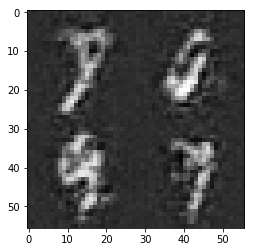

Epoch 2/2... Discriminator Loss: 0.0454... Generator Loss: 3.7533
Epoch 2/2... Discriminator Loss: 0.0447... Generator Loss: 3.7911


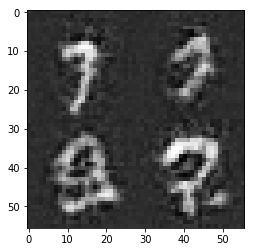

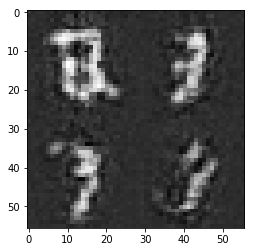

Epoch 2/2... Discriminator Loss: 13.0048... Generator Loss: 17.2266
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 0.8968
Epoch 2/2... Discriminator Loss: 0.5093... Generator Loss: 1.7391


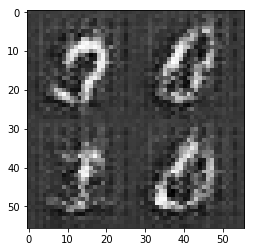

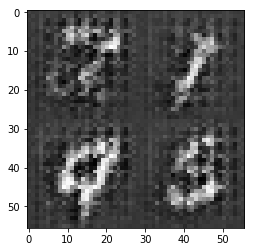

Epoch 2/2... Discriminator Loss: 0.9729... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 0.5821... Generator Loss: 2.6405


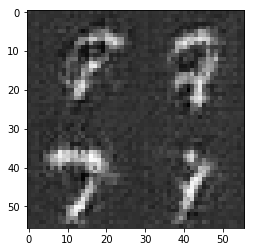

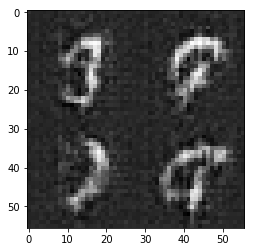

Epoch 2/2... Discriminator Loss: 0.3707... Generator Loss: 1.6550
Epoch 2/2... Discriminator Loss: 0.2591... Generator Loss: 2.3216
Epoch 2/2... Discriminator Loss: 0.1831... Generator Loss: 2.5500


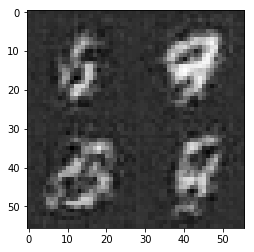

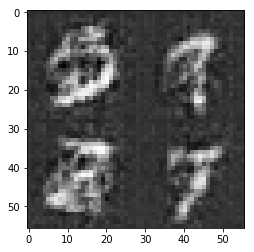

Epoch 2/2... Discriminator Loss: 0.1327... Generator Loss: 2.6181
Epoch 2/2... Discriminator Loss: 0.1675... Generator Loss: 2.4235


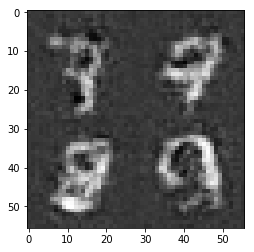

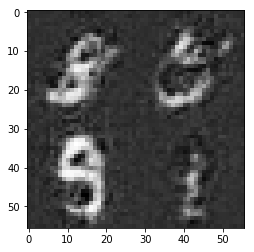

Epoch 2/2... Discriminator Loss: 0.0907... Generator Loss: 2.8829
Epoch 2/2... Discriminator Loss: 0.1148... Generator Loss: 2.8006
Epoch 2/2... Discriminator Loss: 0.0868... Generator Loss: 2.8014


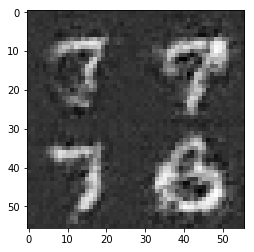

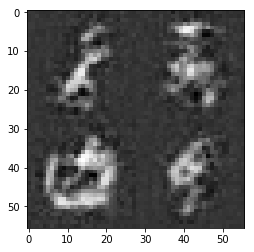

Epoch 2/2... Discriminator Loss: 0.0719... Generator Loss: 3.3012
Epoch 2/2... Discriminator Loss: 0.0694... Generator Loss: 3.3497


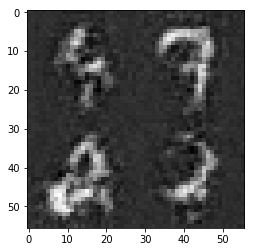

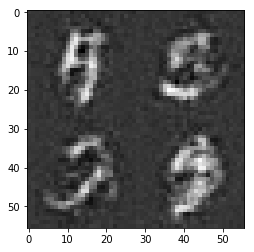

Epoch 2/2... Discriminator Loss: 0.0553... Generator Loss: 3.4561


NameError: name 'pkl' is not defined

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.1416... Generator Loss: 3.1898


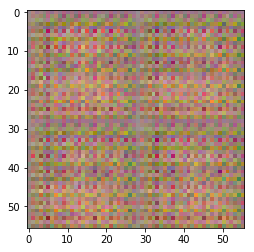

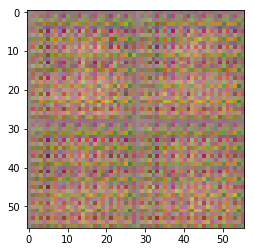

Epoch 1/1... Discriminator Loss: 0.1373... Generator Loss: 2.7319
Epoch 1/1... Discriminator Loss: 0.0587... Generator Loss: 3.9255
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 1.7907


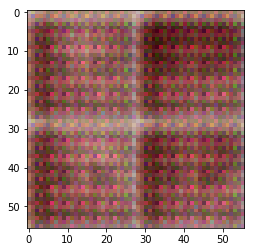

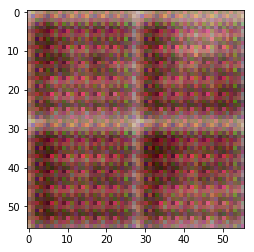

Epoch 1/1... Discriminator Loss: 0.2563... Generator Loss: 2.0679
Epoch 1/1... Discriminator Loss: 0.0948... Generator Loss: 2.7859


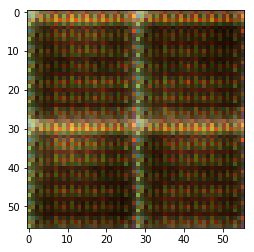

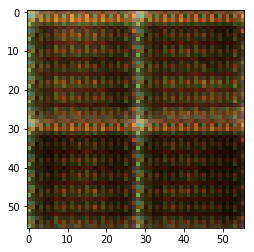

Epoch 1/1... Discriminator Loss: 0.0775... Generator Loss: 3.0324
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 3.7429
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 3.3585


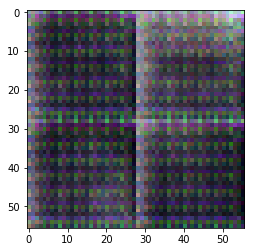

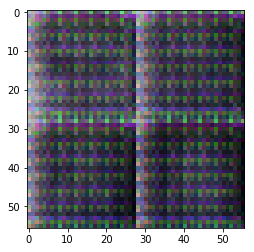

Epoch 1/1... Discriminator Loss: 0.1230... Generator Loss: 3.2330
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 6.2318


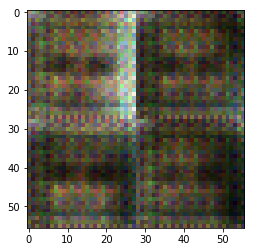

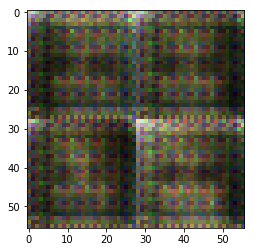

Epoch 1/1... Discriminator Loss: 1.6508... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 3.7354


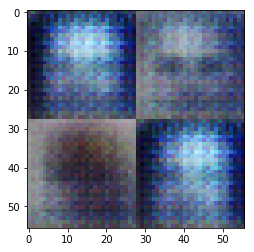

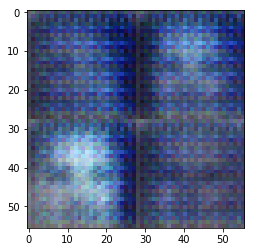

Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 7.5856
Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 4.7785


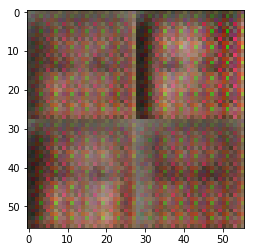

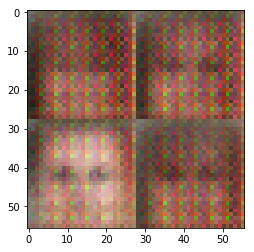

Epoch 1/1... Discriminator Loss: 0.5356... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 4.3390... Generator Loss: 0.0291
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 2.0316


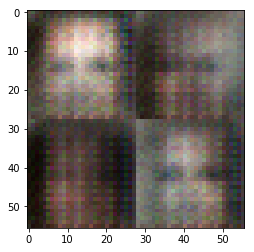

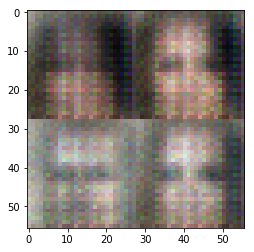

Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 8.5658
Epoch 1/1... Discriminator Loss: 0.0465... Generator Loss: 3.9907


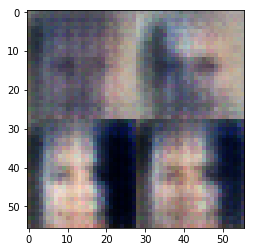

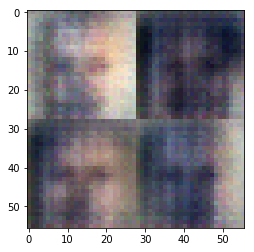

Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 6.5082
Epoch 1/1... Discriminator Loss: 0.0911... Generator Loss: 8.1756


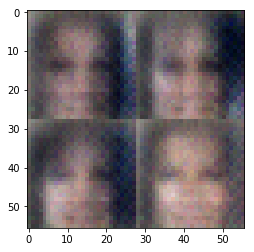

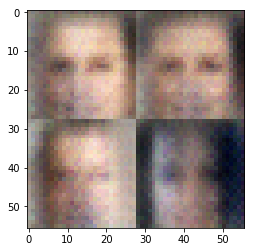

Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 7.0005
Epoch 1/1... Discriminator Loss: 0.0170... Generator Loss: 6.0972


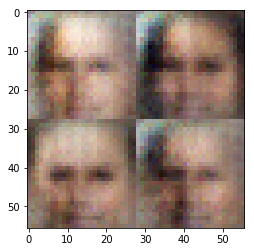

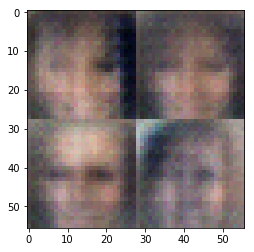

Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 9.5535
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 8.9440
Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 6.4228


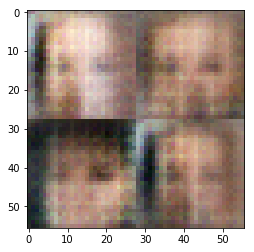

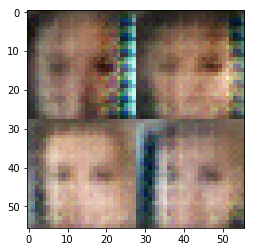

Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 7.3568
Epoch 1/1... Discriminator Loss: 0.0204... Generator Loss: 11.8574


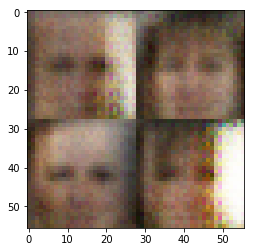

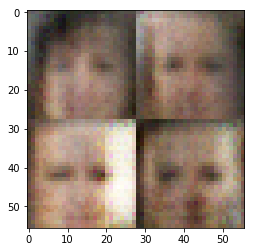

Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 7.0203
Epoch 1/1... Discriminator Loss: 0.0205... Generator Loss: 4.7012
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 7.8487


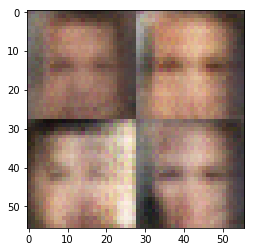

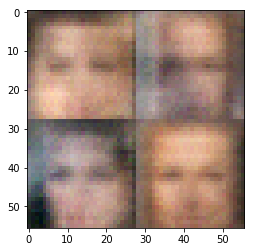

Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 11.7041
Epoch 1/1... Discriminator Loss: 0.0092... Generator Loss: 8.4005


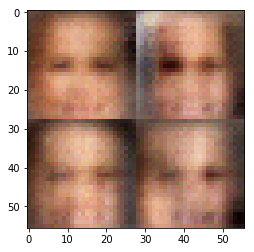

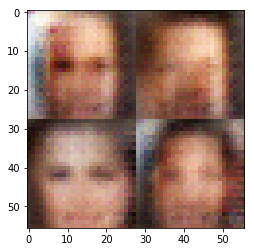

Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 9.5590
Epoch 1/1... Discriminator Loss: 0.0308... Generator Loss: 8.6542
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.1293


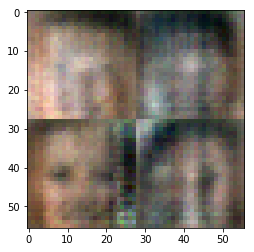

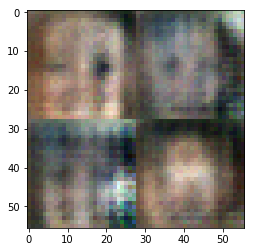

Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 9.3695
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 7.7998


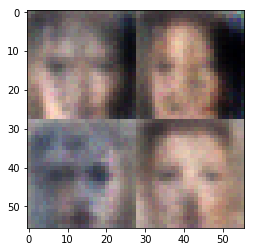

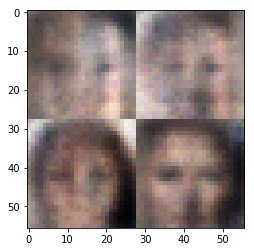

Epoch 1/1... Discriminator Loss: 0.2467... Generator Loss: 10.6239
Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 11.4945
Epoch 1/1... Discriminator Loss: 0.0315... Generator Loss: 3.9294


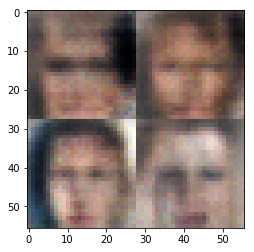

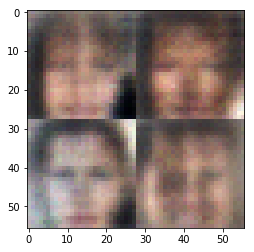

Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.4775
Epoch 1/1... Discriminator Loss: 0.0842... Generator Loss: 3.1303


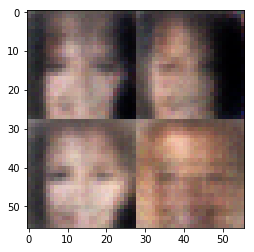

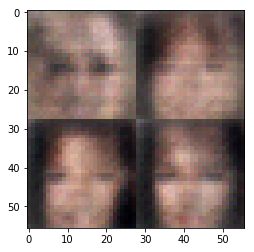

Epoch 1/1... Discriminator Loss: 0.0109... Generator Loss: 5.6942
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 7.2123
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 15.8649


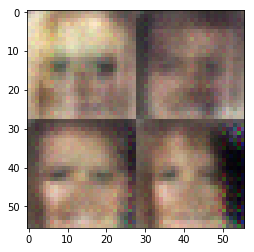

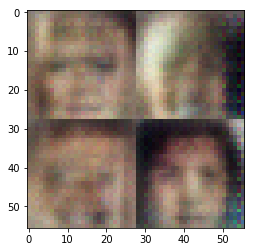

Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 10.3979
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 4.3144


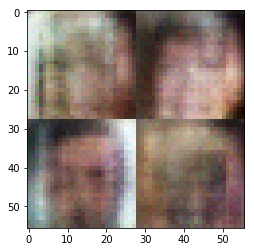

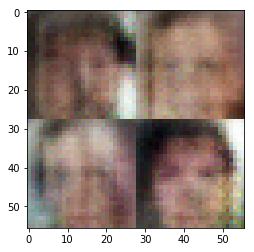

Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 11.8901
Epoch 1/1... Discriminator Loss: 0.0055... Generator Loss: 10.6422
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 10.4760


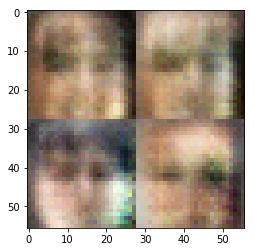

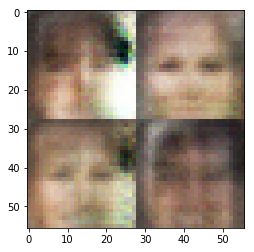

Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 9.9400
Epoch 1/1... Discriminator Loss: 0.0777... Generator Loss: 4.1326


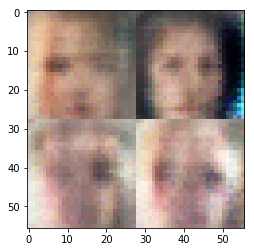

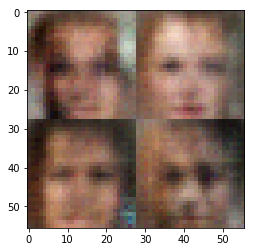

Epoch 1/1... Discriminator Loss: 0.0715... Generator Loss: 3.5644
Epoch 1/1... Discriminator Loss: 0.0707... Generator Loss: 8.1222
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 9.6061


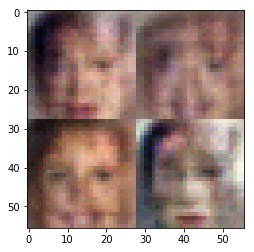

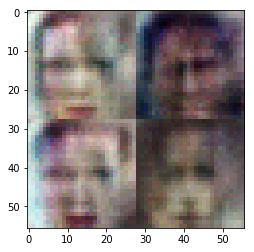

Epoch 1/1... Discriminator Loss: 0.0169... Generator Loss: 10.5566
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 8.7244


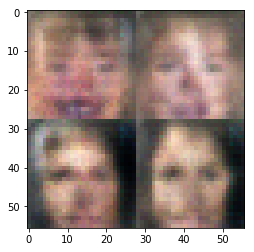

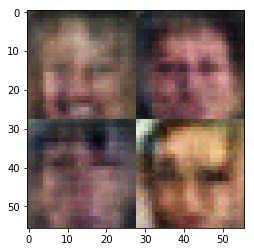

Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 7.3318
Epoch 1/1... Discriminator Loss: 0.0669... Generator Loss: 3.6043
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 5.5946


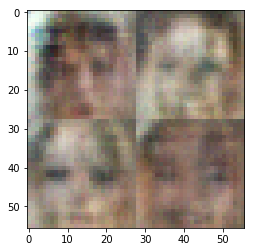

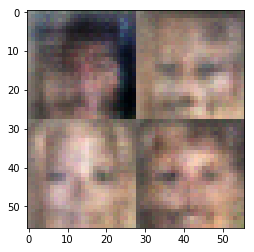

Epoch 1/1... Discriminator Loss: 0.2522... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 8.0502


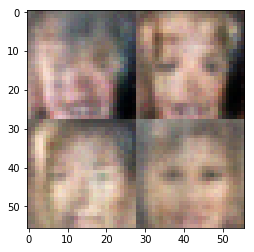

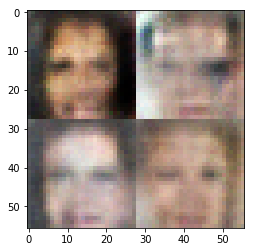

Epoch 1/1... Discriminator Loss: 0.0095... Generator Loss: 8.2428
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 9.2227
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 8.4241


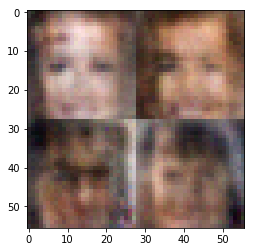

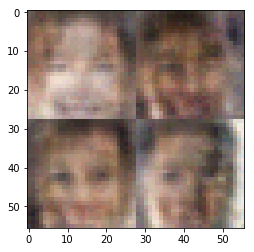

Epoch 1/1... Discriminator Loss: 0.0133... Generator Loss: 5.7943
Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 4.5280


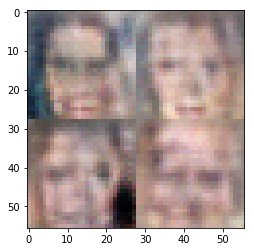

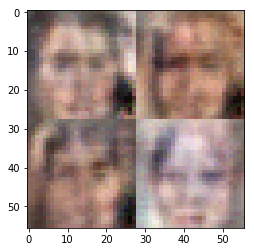

Epoch 1/1... Discriminator Loss: 0.2335... Generator Loss: 5.3952
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 7.6971
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 11.1801


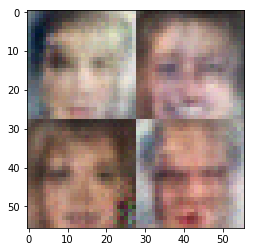

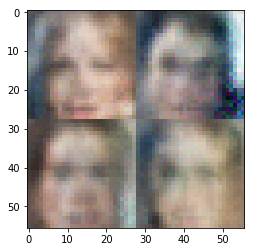

Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 0.2152... Generator Loss: 2.3184


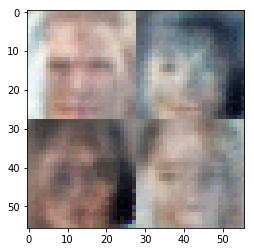

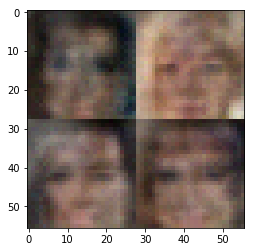

Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 8.2113
Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 10.8209
Epoch 1/1... Discriminator Loss: 0.0862... Generator Loss: 3.3684


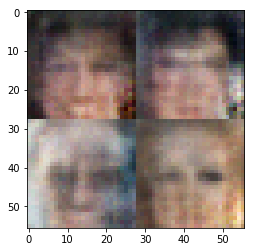

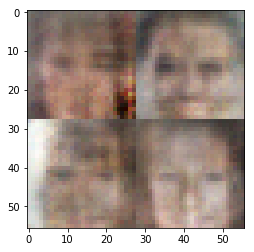

Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 5.9774
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 7.8819


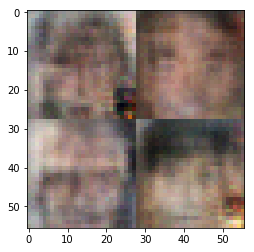

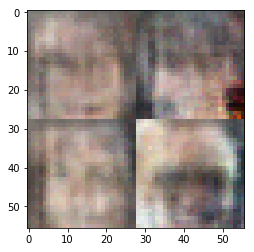

Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 5.8356
Epoch 1/1... Discriminator Loss: 0.0154... Generator Loss: 5.2767
Epoch 1/1... Discriminator Loss: 0.0192... Generator Loss: 4.6028


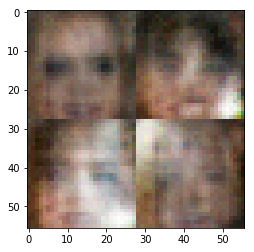

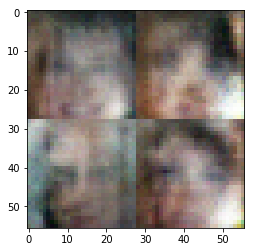

Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.4733
Epoch 1/1... Discriminator Loss: 0.0490... Generator Loss: 4.3313


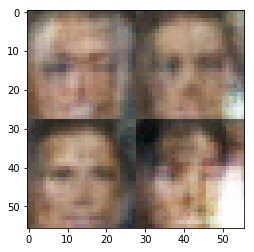

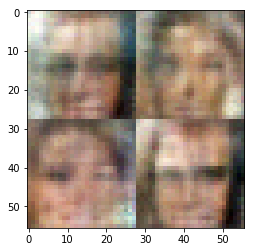

Epoch 1/1... Discriminator Loss: 0.0148... Generator Loss: 9.7644
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 5.6523
Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 8.5088


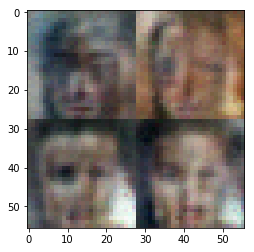

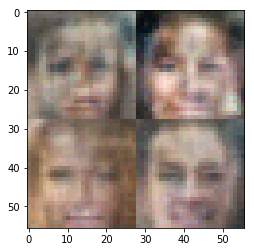

Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 16.8250
Epoch 1/1... Discriminator Loss: 0.0102... Generator Loss: 10.2038


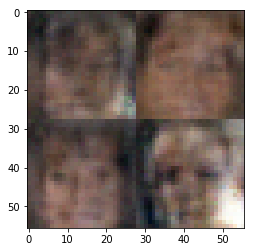

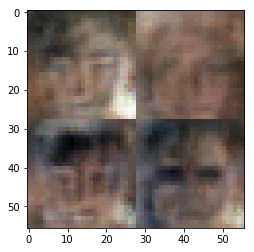

Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 6.5041
Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 10.4439
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 6.4212


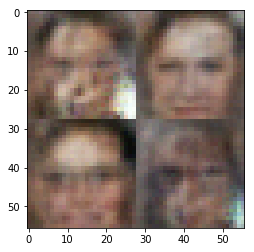

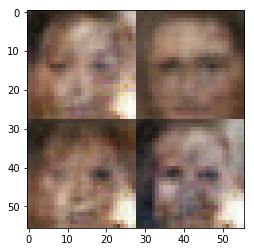

Epoch 1/1... Discriminator Loss: 0.0121... Generator Loss: 8.5296
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.5925


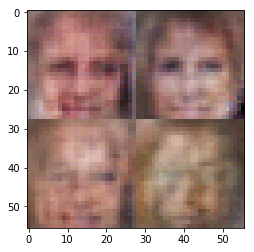

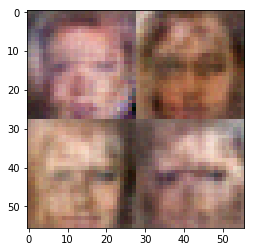

Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 10.3628
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 9.3406
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 8.4879


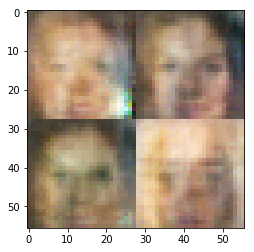

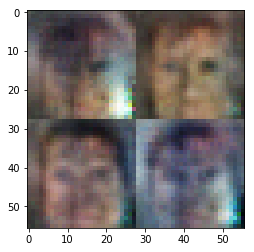

Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 6.5958
Epoch 1/1... Discriminator Loss: 0.0218... Generator Loss: 6.1764


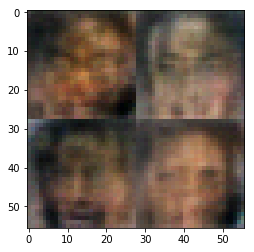

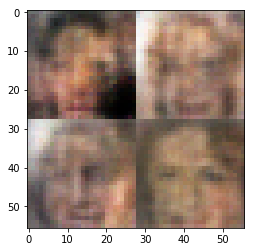

Epoch 1/1... Discriminator Loss: 0.0324... Generator Loss: 9.7788
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 12.3345
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 4.6872


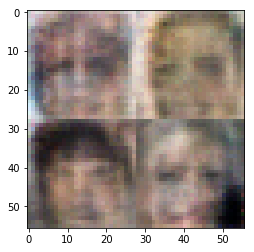

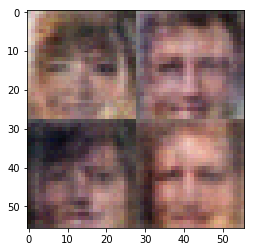

Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 9.6834
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 11.1360


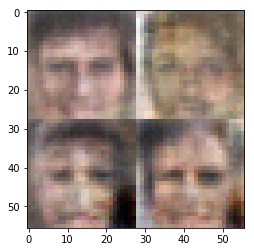

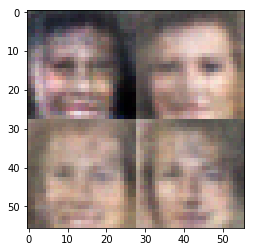

Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 9.4726
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 9.2622
Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 4.7470


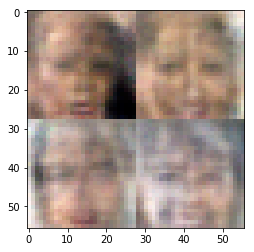

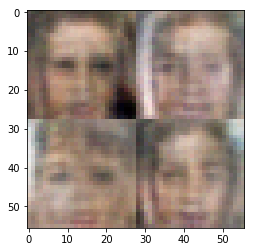

Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 10.6938
Epoch 1/1... Discriminator Loss: 0.0197... Generator Loss: 6.9613


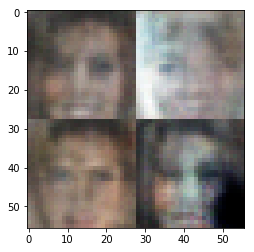

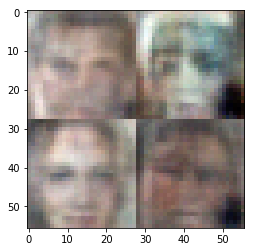

Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 1.8265
Epoch 1/1... Discriminator Loss: 0.0407... Generator Loss: 3.7201
Epoch 1/1... Discriminator Loss: 7.4576... Generator Loss: 0.0010


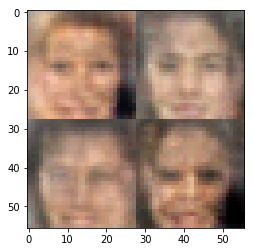

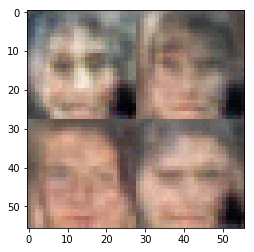

Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 8.6722
Epoch 1/1... Discriminator Loss: 0.0865... Generator Loss: 3.5597


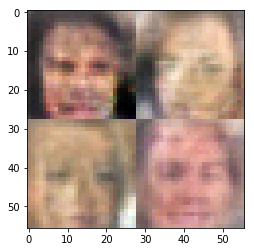

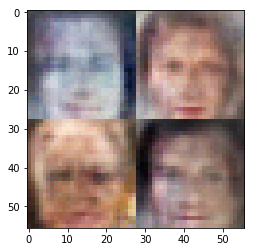

Epoch 1/1... Discriminator Loss: 0.0935... Generator Loss: 7.5034
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 8.5665
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 13.1219


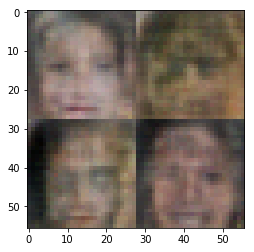

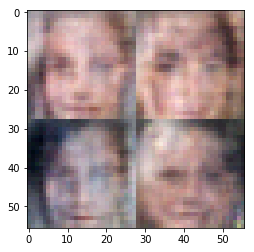

Epoch 1/1... Discriminator Loss: 0.0747... Generator Loss: 3.4991
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 2.0180


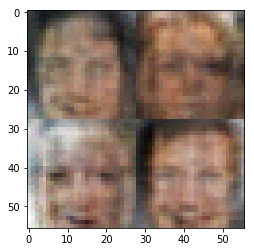

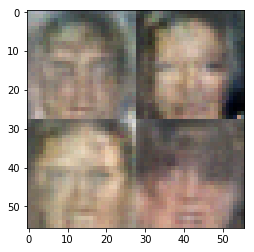

Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 10.9350
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 7.6492
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 6.6302


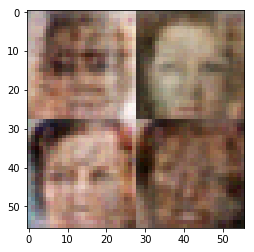

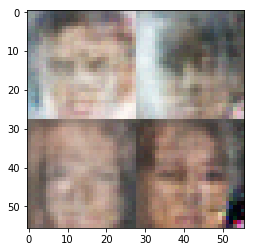

Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 10.9219
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 8.9731


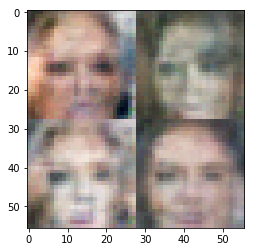

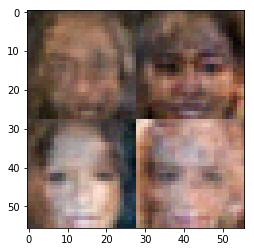

Epoch 1/1... Discriminator Loss: 1.7377... Generator Loss: 6.1481
Epoch 1/1... Discriminator Loss: 0.1731... Generator Loss: 5.8707
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 5.5540


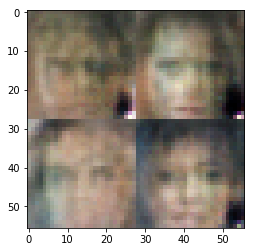

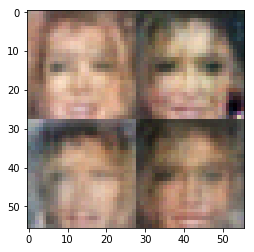

Epoch 1/1... Discriminator Loss: 0.0552... Generator Loss: 4.5527
Epoch 1/1... Discriminator Loss: 0.0868... Generator Loss: 3.0590


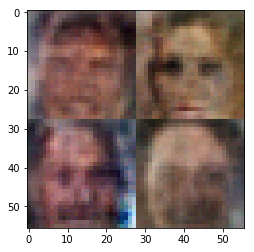

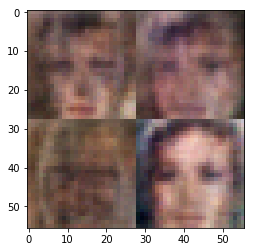

Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 10.1307
Epoch 1/1... Discriminator Loss: 0.0553... Generator Loss: 4.0739
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 7.1498


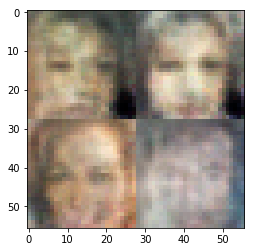

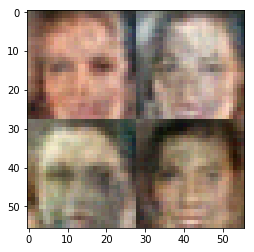

Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 6.7599
Epoch 1/1... Discriminator Loss: 3.0524... Generator Loss: 11.4347


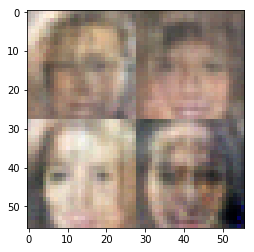

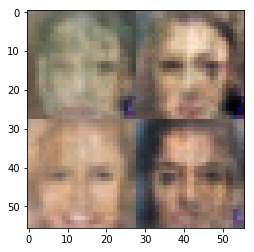

Epoch 1/1... Discriminator Loss: 0.2082... Generator Loss: 5.6412
Epoch 1/1... Discriminator Loss: 0.0158... Generator Loss: 14.8750
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 7.8753


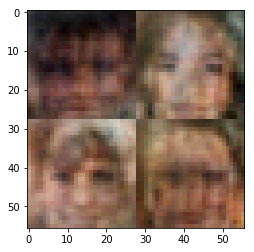

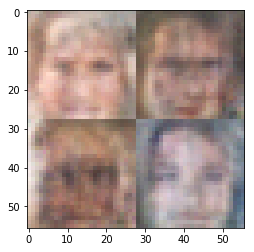

Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 2.5689
Epoch 1/1... Discriminator Loss: 0.2326... Generator Loss: 2.8377


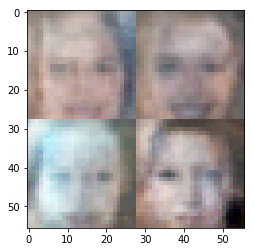

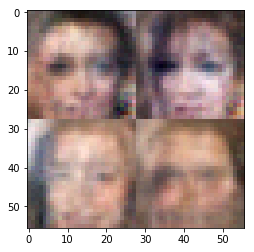

Epoch 1/1... Discriminator Loss: 0.1675... Generator Loss: 2.8292
Epoch 1/1... Discriminator Loss: 0.0370... Generator Loss: 8.9815
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 12.0919


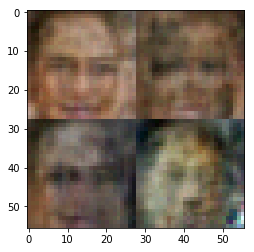

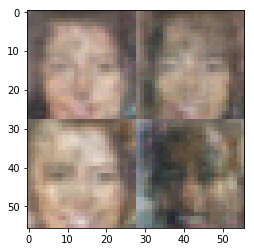

Epoch 1/1... Discriminator Loss: 0.0087... Generator Loss: 6.9659
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 8.6539


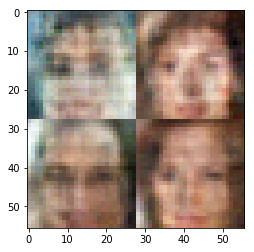

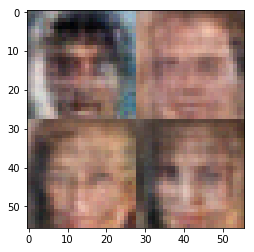

Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 9.2467
Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 7.6166
Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.5579


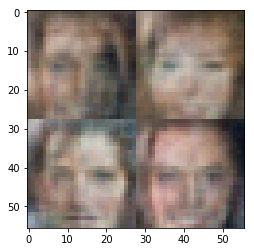

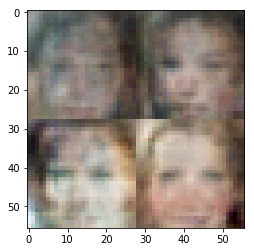

Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 14.3348
Epoch 1/1... Discriminator Loss: 0.2714... Generator Loss: 2.2168


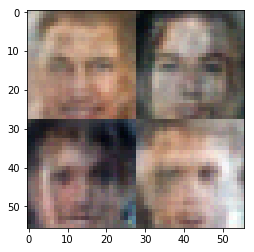

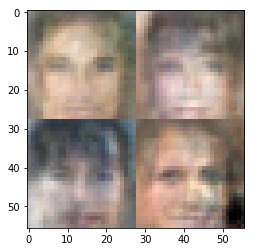

Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 6.4108
Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 3.0756


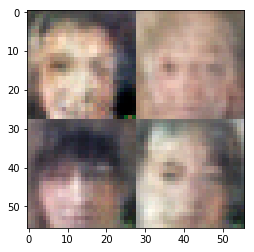

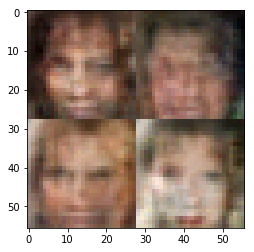

Epoch 1/1... Discriminator Loss: 0.0346... Generator Loss: 5.2033
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 6.1022


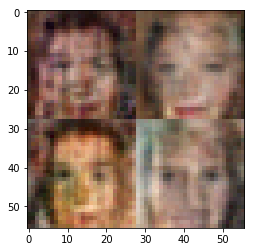

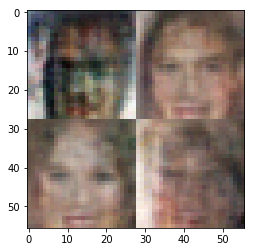

Epoch 1/1... Discriminator Loss: 0.0165... Generator Loss: 8.2728
Training done!


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.